In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pdb

%matplotlib inline

In [2]:
import board, config, environment

In [3]:
tf.reset_default_graph()

In [4]:
# Parameters
board_size = 5
board_array_size = (board_size -1) * board_size * 2
env = environment.Environment(board_size)

def state_to_input(state):
    rtn = np.zeros(np.power((2 * board_size - 1), 2))
    for i, value in enumerate(state):
        rtn[2 * i + 1] = value
    return rtn.reshape((2 * board_size - 1, 2 * board_size - 1))

def output_to_state(output):
    output = np.reshape(output, -1)
    rtn = np.zeros(board_array_size)
    for i, value in enumerate(output):
        if i % 2 == 1:
            rtn[(i-1) / 2] = value
    return rtn

In [5]:
class SimpleNet:
    def __init__(self):
        self.session = tf.Session()
        
        #These lines establish the feed-forward part of the network used to choose actions
        self.input = tf.placeholder(shape=[1, board_array_size],dtype=tf.float32)
        self.W = tf.Variable(tf.random_uniform([board_array_size,board_array_size],0,0.01))
        self.Qout = tf.matmul(self.input,self.W)
        self.predict = tf.argmax(self.Qout,1)

        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.nextQ = tf.placeholder(shape=[1,board_array_size],dtype=tf.float32)
        self.loss = tf.reduce_sum(tf.square(self.nextQ - self.Qout))
        self.trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        self.updateModel = self.trainer.minimize(self.loss)
    
    def get_session(self):
        return self.session
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.session.close() 

In [5]:
class ConvNet:
    def __init__(self):
        self.session = tf.Session()
        num_moves = (2 * board_size - 1) * (board_size - 1) + board_size - 1
        # Two conv + relu + max_pool layers
        self.input = tf.placeholder(shape=[1, 2 * board_size - 1, 2 * board_size - 1, 1], dtype=tf.float32)
        layer1 = self.create_new_conv_layer(input_data = self.input, 
                                            num_input_channels = 1, 
                                            num_filters = 32, 
                                            filter_shape = [3, 3], 
                                            pool_shape = [2, 2], 
                                            name='layer1')
        layer2 = self.create_new_conv_layer(input_data = layer1, 
                                            num_input_channels = 32, 
                                            num_filters = 64, 
                                            filter_shape = [5, 5], 
                                            pool_shape = [2, 2], 
                                            name='layer2')
        flattened = tf.reshape(layer2, [-1, 3 * 3 * 64])
                
        # setup some weights and bias values for this layer, then activate with ReLU
        wd1 = tf.Variable(tf.truncated_normal([3 * 3 * 64, 1000], stddev=0.03), name='wd1')
        bd1 = tf.Variable(tf.truncated_normal([1000], stddev=0.01), name='bd1')
        dense_layer1 = tf.matmul(flattened, wd1) + bd1
        dense_layer1 = tf.nn.relu(dense_layer1)
        
        # another layer with softmax activations
        wd2 = tf.Variable(tf.truncated_normal([1000, num_moves], stddev=0.03), name='wd2')
        bd2 = tf.Variable(tf.truncated_normal([num_moves], stddev=0.01), name='bd2')
        self.Qout = tf.matmul(dense_layer1, wd2) + bd2
        self.predict = tf.argmax(self.Qout, 1)
        
        # Loss
        self.nextQ = tf.placeholder(shape=[1, (2 * board_size - 1) * (board_size - 1) + board_size - 1], dtype=tf.float32)
        # cross_entropy
#         self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.Qout, labels=self.nextQ))       
#         self.updateModel = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(self.loss)
        
        self.td_error = tf.square(self.Qout - self.nextQ)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
    def create_new_conv_layer(self, input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
        # setup the filter input shape for tf.nn.conv_2d
        conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                          num_filters]
        
        # initialise weights and bias for the filter
        weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                          name=name+'_W')
        bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

        # setup the convolutional layer operation
        out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

        # add the bias
        out_layer += bias

        # apply a ReLU non-linear activation
        out_layer = tf.nn.relu(out_layer)

        # now perform max pooling
        ksize = [1, pool_shape[0], pool_shape[1], 1]
        strides = [1, 2, 2, 1]
        out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                                   padding='SAME')

        return out_layer
    
    def get_session(self):
        return self.session
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.session.close() 
        
    

In [6]:
def filter_possible_moves(s, allQ):
    #min_num = np.min(allQ) -1
    #filteredQ = (s == 0) * (allQ - min_num) + min_num
    #if np.isnan(filteredQ).any():
    #    pdb.set_trace()
    filteredQ = allQ
    return np.argmax(filteredQ), np.max(filteredQ), filteredQ

In [ ]:
with ConvNet() as NN:
    
    # Initialize NN
    sess = NN.get_session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Set learning parameters
    y = .99
    e = 0.1
    num_episodes = 10000
    
    #create lists to contain total rewards and steps per episode
    jList = []
    rList = []

    for i in range(num_episodes):
        
        if i % 10 == 0:
            print i
            if len(rList) > 0:
                print "Average score from episode " + str(i - 10) + " to " + str(i) + " is:" + str(np.average(rList[-10:]))
                
        #Reset environment and get first new observation
        state = env.reset()
        rAll = 0
        d = False
        j = 0

        #The Q-Network
        while d < 1:
            
            #Choose an action by greedily (with e chance of random action) from the Q-network
            state_input = np.reshape(state_to_input(state[0]), [-1, 2 * board_size - 1, 2 * board_size - 1, 1])
            allQ = sess.run(NN.Qout,feed_dict={NN.input: state_input})
            action, _, filteredQ = filter_possible_moves(state, allQ.reshape(-1))

            #pdb.set_trace()
            if np.random.rand(1) < e:
                action = env.action_space_sample()
                
            # Make sure that action isn't null
            try:
                assert isinstance(action, int)
            except:
                print "Caught error at: episode " + str(i) + " and step " + str(j) + "."
                print "========================="
                print "allQ\n========================="
                print allQ
                print "state\n========================="
                print state
                print "action\n========================="
                print action
                print type(action)
                
            #Get new state and reward from environment
            next_state, reward, d = env.step(action)

            #Obtain the Q' values by feeding the new state through our network
            next_state =np.reshape(state_to_input(next_state[0]), [-1, 2 * board_size - 1, 2 * board_size - 1, 1])
            next_Q = sess.run(NN.Qout, feed_dict = {NN.input: next_state})

            #Obtain maxQ' and set our target value for chosen action.
            _, max_next_Q, _ = filter_possible_moves(next_state, next_Q)
            targetQ = filteredQ
            targetQ[action] = reward + y * max_next_Q

            #Train our network using target and predicted Q values
            _, _, predictedQ = sess.run([NN.updateModel, NN.loss, NN.Qout], 
                                        feed_dict={NN.input: state_input, NN.nextQ: targetQ.reshape((1, board_array_size))})
            if d != 0:
                rAll += reward
            state = output_to_state(next_state).reshape((1, board_array_size))

            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
            
            j += 1

        jList.append(j)
        rList.append(rAll)
        

0
10
Average score from episode 0 to 10 is:-3.8
20
Average score from episode 10 to 20 is:-5.4
30
Average score from episode 20 to 30 is:-3.4
40
Average score from episode 30 to 40 is:-5.5
50
Average score from episode 40 to 50 is:-2.7
60
Average score from episode 50 to 60 is:-5.4
70
Average score from episode 60 to 70 is:-2.4
80
Average score from episode 70 to 80 is:-6.4
90
Average score from episode 80 to 90 is:-4.8
100
Average score from episode 90 to 100 is:-5.6
110
Average score from episode 100 to 110 is:-3.9
120
Average score from episode 110 to 120 is:-4.7
130
Average score from episode 120 to 130 is:-4.9
140
Average score from episode 130 to 140 is:-2.2
150
Average score from episode 140 to 150 is:-3.1
160
Average score from episode 150 to 160 is:-4.7
170
Average score from episode 160 to 170 is:-6.5
180
Average score from episode 170 to 180 is:-6.0
190
Average score from episode 180 to 190 is:-5.6
200
Average score from episode 190 to 200 is:-2.6
210
Average score from epis

1620
Average score from episode 1610 to 1620 is:-5.7
1630
Average score from episode 1620 to 1630 is:-6.5
1640
Average score from episode 1630 to 1640 is:-3.5
1650
Average score from episode 1640 to 1650 is:-4.5
1660
Average score from episode 1650 to 1660 is:-2.8
1670
Average score from episode 1660 to 1670 is:-4.1
1680
Average score from episode 1670 to 1680 is:-3.7
1690
Average score from episode 1680 to 1690 is:-5.5
1700
Average score from episode 1690 to 1700 is:-5.1
1710
Average score from episode 1700 to 1710 is:-4.4
1720
Average score from episode 1710 to 1720 is:-4.4
1730
Average score from episode 1720 to 1730 is:-4.6
1740
Average score from episode 1730 to 1740 is:-3.2
1750
Average score from episode 1740 to 1750 is:-6.3
1760
Average score from episode 1750 to 1760 is:-4.0
1770
Average score from episode 1760 to 1770 is:-5.7
1780
Average score from episode 1770 to 1780 is:-4.5
1790
Average score from episode 1780 to 1790 is:-6.8
1800
Average score from episode 1790 to 1800 i

3170
Average score from episode 3160 to 3170 is:-4.8
3180
Average score from episode 3170 to 3180 is:-3.8
3190
Average score from episode 3180 to 3190 is:-4.4
3200
Average score from episode 3190 to 3200 is:-4.1
3210
Average score from episode 3200 to 3210 is:-5.5
3220
Average score from episode 3210 to 3220 is:-5.8
3230
Average score from episode 3220 to 3230 is:-3.6
3240
Average score from episode 3230 to 3240 is:-4.0
3250
Average score from episode 3240 to 3250 is:-5.9


In [10]:
wins = np.array(rList) > 0

print "Percent of succesful episodes: " + str(float(np.sum(wins))/num_episodes) + "%"

Percent of succesful episodes: 0.173%


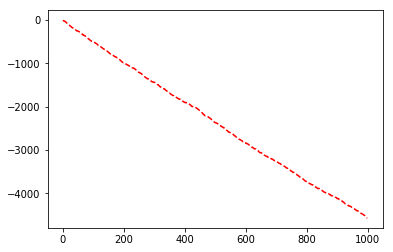

In [11]:
rList_cumsum = np.cumsum(rList)
plt.plot(rList_cumsum, '--r')

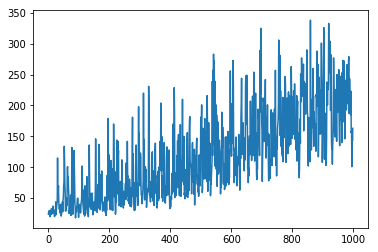

In [12]:
plt.plot(jList)

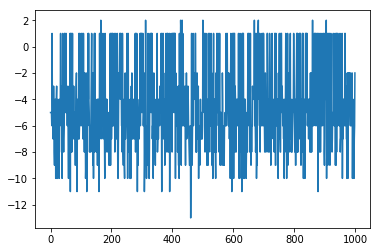

In [13]:
plt.plot(rList)

In [24]:
winrate = [float(sum(np.array(rList[i:i+10])>0))/10 for i in range(200)]

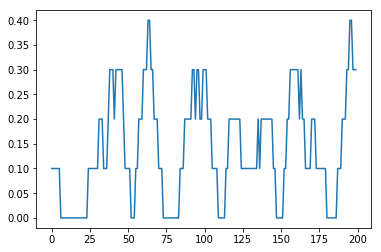

In [25]:
plt.plot(winrate)